# Fys245 Oblig 
### Johan Zapffe og Astrid Moum

grpgfsd


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import seaborn as sns

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet (Sett inn figur?)

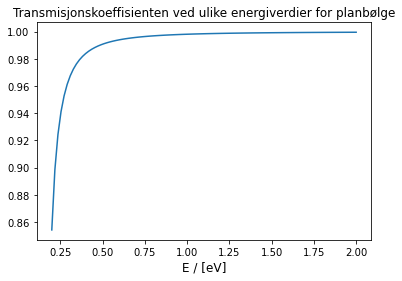

In [15]:
def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T

# ================================
# Energy høyere enn potensialet
# ================================
E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()

In [16]:
# ============================
# Energi lavere enn potensialet
# ============================



## Oppgave 2


### Stationary states


In [17]:
def psi_n(L, x, n):
    """
    Funsjon for å finne den n'te stasjonære tilstanden til ??.
    
    Inputs
    ------
    L - 
    x -
    n - 
    
    Returns
    -------
    
    
    """
    return np.sqrt(2/L) * np.sin(n * np.pi * x / L )



### Bølgepakken

In [22]:
sigma = 1* 1e-8  # [m]
E = 0.20  # [eV]
V0 = 0.16  # [eV]
m = 9.11 * 1e-31  # [kg]
x0 = 50 * 1e-9  # [m]
L = 200 * 1e-9  # [m]
h_bar = 6.582 * 1e-16  # [eV*s]

t = 0
dt = 2.25 * 1e-19  # [s]
dx = 1.5 * 1e-10  # [m]

def V(x):
    """
    The potential energy of the particle. Will be infinite 
    
    Returns:
    --------
    float
        The potential energy of the particle   
    """
    inf=math.exp(15)
    
    V_list = []
    
    for xi in x:
        if xi <= 0 or xi >= L:
            V_list.append(inf)
        elif 0 < xi < L/2:
            V_list.append(0)
        else:
            V_list.append(V0)
    return V_list

def Phi(x, x0, t, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    neste_tidssteg - float
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    scnd_d_x = ksi(x+dx, x0, t) - 2*ksi(x, x0, t) + ksi(x-dx, x0, t) / dx**2  # Den andre deriverte av ksi mhp x
    neste_tidssteg = ksi(x, x0, t) + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/2*m) + ksi(x, x0, t) * V(x))
    
    return neste_tidssteg




def ksi(x, x0, t):
    """
    Den stasjonære bølgepakken (tidsavhengig)
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
    
    t - float
        Tiden som vi observerer bølgepakken ved
    
    Returns
    -------
    float
        stasjonær bølgepakke
    """
    k = np.sqrt(2*m*E) / h_bar
    time_dependent_ksi = np.exp(1j*E*t/h_bar)
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2))) * np.exp(1j*k*(x-x0)) * time_dependent_ksi

x = np.linspace(0, L, 100)
for _ in range(50):
        
    hei = ksi(x, x0, t)
    print(hei)
    t+= dt
    
t = 0
for xi in x:
    t += dt
    #print(xi)
    hei = ksi(xi, x0, t)
    #print(hei)
    hei2 = ksi_neste_tidssteg(xi, x0, t, dt, dx)
    print(hei2)

[2.79918439e-02-1.28360919e-09j 7.53096370e-02-3.31390669e-09j
 1.94511420e-01-8.19884380e-09j 4.82297663e-01-1.94357152e-08j
 1.14804976e+00-4.41372145e-08j 2.62350425e+00-9.60008283e-08j
 5.75543741e+00-1.99942775e-07j 1.21213335e+01-3.98634485e-07j
 2.45074413e+01-7.60569471e-07j 4.75686737e+01-1.38812223e-06j
 8.86379327e+01-2.42235475e-06j 1.58560022e+02-4.03945247e-06j
 2.72297265e+02-6.43249669e-06j 4.48919391e+02-9.77309991e-06j
 7.10507969e+02-1.41515342e-05j 1.07955568e+03-1.95018480e-05j
 1.57469569e+03-2.55288235e-05j 2.20507689e+03-3.16629626e-05j
 2.96432857e+03-3.70728710e-05j 3.82564304e+03-4.07566422e-05j
 4.73977857e+03-4.17136093e-05j 5.63750791e+03-3.91691853e-05j
 6.43712257e+03-3.27982430e-05j 7.05621648e+03-2.28789480e-05j
 7.42553103e+03-1.03184601e-05j 7.50168185e+03+3.47475955e-06j
 7.27554060e+03+1.68500576e-05j 6.77403443e+03+2.82394364e-05j
 6.05487293e+03+3.64598184e-05j 5.19562946e+03+4.09122352e-05j
 4.28002998e+03+4.16324742e-05j 3.38478396e+03+3.919557

TypeError: 'numpy.float64' object is not iterable

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


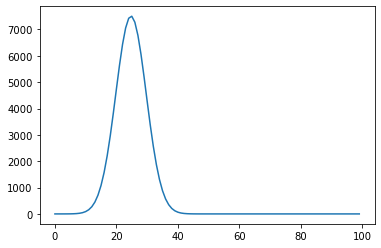

[3269017.3724721107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 3269017.3724721107]


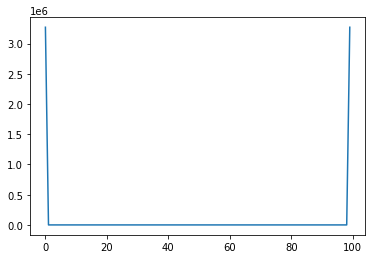

100
100


C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


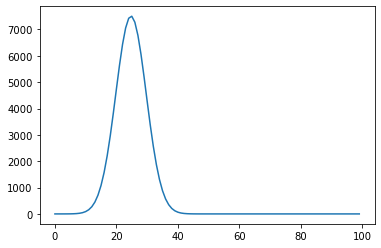

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


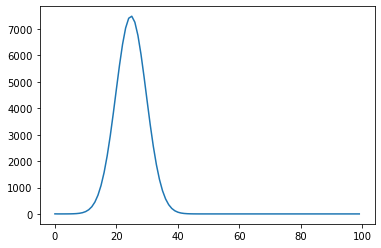

In [27]:
def plot_ksi(t):
    """
    Funksjon for å plotte bølgefunksjonen ksi ved gitt tidspunkt
    
    Inputs
    ------
    t - float
        Tiden vi ønsker å plotte bølgefunksjonen ved
    
    Returns
    -------
        plot av bølgefunksjonen ved gitt tidspunkt
    """
    pass

ff = ksi(x, x0, t=0)
plt.plot(ff)
plt.show()

print(V(x))
plt.plot(V(x))
plt.show()
print(len(x))
print(len(V(x)))

f2 = Phi(x, x0, t, dt, dx)
plt.plot(f2)
plt.show()

f3 = Phi(x, x0, t+dt*1000, dt, dx)
plt.plot(f3)
plt.show()


Uttrykket psi I, hva skal det bygge på? Skal det komme av likning 1? Skal det kombineres med likning 4?


Hvordan finne c_n?
Gjøres ved å numerisk integrere phi_n(komlpekskonjugert)* phi fra -inf til inf




## Oppgave 3
Undersøkelse av hvordan innfallsvinkel påvirker nnsynligheten for at elektroner blir transmittert.
Systemet blir beskrevet vha planbølge


Beregne T(E, alpha)

In [ ]:
V0 = 0.16  # [eV]
E = np.linspace(0.4, 0.2, 10)  # eV
alpha = np.linspace(0, 30, 10)  # degrees


#E = 0.2
#alpha = 0
m = 9.11 * 1e-31  # mass of electron [kg]
h_bar = 6.582 * 1e-16  # [eV*s]

In [ ]:
def T(E, V0, alpha):
    """
    Funksjon for å beregne transmisjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen
    V0- float
        Den potensielle energien til potensialtrinnet
    alpha - float
        Innfallsvinkel til planbølgen
    
    Returns
    -------
    float
        Transmisjonskoeffisienten til planbølgen
    """
    T = np.zeros([len(E), len(alpha)])
    _alpha = np.deg2rad(alpha)
    
    for i, _E in enumerate(E):
        k = np.sqrt(2*m*_E) / h_bar  # likn 9
        k_y = k * np.sin(_alpha)  # likn 12
    
        k0_2 = (np.sqrt(2*m*(_E-V0)) / h_bar) **2
        k0_x = np.sqrt(k0_2 - k_y**2)
        k0 = np.sqrt(k0_x**2 + k_y**2)
    
        T[i] = 4 * k * k0 / (k + k0) ** 2
    
    return T

def R(E, alpha):
    """
    Funksjon for å beregne refleksjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen [eV]
    alpha - float
        Innfallsvinkel til planbølgen [grader]
    
    Returns
    -------
    float
        Refleksjonskoeffisienten til planbølgen
    """
    pass

# Regne ut transmisjonskoeffisienten for energi- og alpha-verdier
T_values = T(E, V0, alpha)

# Plotte transmisjonskoeffisienten
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=T_values, annot=True, fmt='.4g', xticklabels=alpha.round(2), yticklabels=E.round(2))
ax.set(xlabel=r'$\alpha [\degree]$', ylabel='Energy [eV]', title='Transmisjonskoeffisienten for planbølger med ulik energi og innfallsvinkel')
plt.show()

Når alpha har høy verdi (eks 30 grader) og energien til bølgepakken er lav (eks 0.2 eV) vil utregningen av k0_x gi
NaN. 
k0_x = np.sqrt(k0_2 - k_y ** 2)

Dette er fordi k0^2 - ky^2 < 0. Dermed får vi noe negativt under rottegn.

# SPØRSMÅL ONSDAG:
I praksis så vil det si at alt reflekteres og ingenting transmitteres(?). Teoretisk sett, hva vil det si at vi får et komplekst tall for transmisjonskoeffisienten?

Hvem har skrevet teksten til obligen?? (mtp kilde)